## Imports

In [4]:
import numpy as np
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from shapely import Polygon, Point
from bbtoolkit.preprocessing.environment import EnvironmentBuilder, EnvironmentCompiler,\
    PrecomputedVisiblePlane, LazyVisiblePlane, AsyncVisiblePlane
from bbtoolkit.structures.geometry import TexturedPolygon, Texture
import time
from matplotlib import pyplot as plt
from bbtoolkit.preprocessing.environment.viz import plot_polygon
from collections import OrderedDict
from functools import partial
from bbtoolkit.data import Cached

#### Helper functions

In [5]:
def create_circular_polygon(center: Point, radius: float, num_points: int = 100):
    """
    Creates a circular polygon with the specified center and radius.

    Args:
        center (Point): The center of the circle.
        radius (float): The radius of the circle.
        num_points (int, optional): The number of points to use for generating the polygon (default is 100).

    Returns:
        Polygon: A polygon representing the circle.
    """
    # Generate points on the circle
    circle_points = [(center.x + np.cos(2 * np.pi / num_points * x) * radius, center.y + np.sin(2 * np.pi / num_points * x) * radius) for x in range(num_points)]

    # Create the Polygon
    circle = Polygon(circle_points)

    return circle

## Build Environment

#### Initialize Environment Builder

In [6]:
min_xy, max_xy = -10, 10 # create the box of size 20x20
min_train_x, max_train_x, min_train_y, max_train_y = -10, 10, 0, 10 # create the training area of size 20x10
res = 0.2 # set grid resolution

builder = EnvironmentBuilder(
    min_xy,
    max_xy,
    (min_train_x, min_train_y),
    (max_train_x, max_train_y),
    res=res
)

### Visualize Environment layout

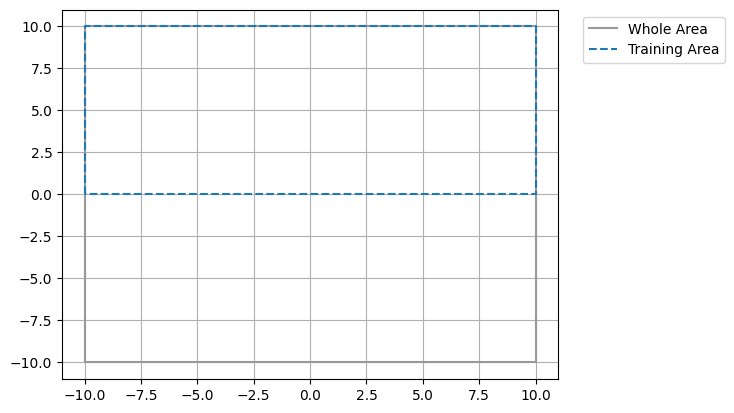

In [7]:
fig = builder.plot()

### Add walls

In [8]:
builder.add_wall(
    TexturedPolygon(
    create_circular_polygon(Point(0, 0), 10, 5) - create_circular_polygon(Point(0, 0), 9, 5),
    texture=Texture(
        1,
        '#4b0082',
        'main_wall'
    )
    )
)

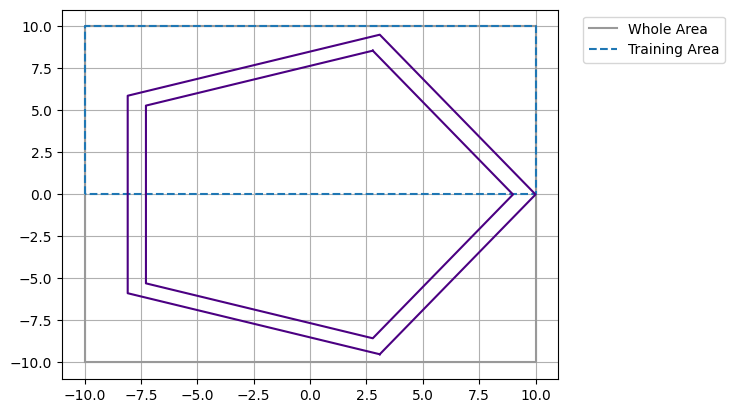

In [9]:
_ = builder.plot()

### Add objects

In [10]:
builder.add_object(
    TexturedPolygon(
        [
            Point(-5, 2.5),
            Point(-5, -2.5),
            Point(-4.5, -2.5),
            Point(-4.5, 2.5)
        ],
        texture=Texture(
            21,
            '#9c273a',
            'obj_bound_1'
        )
    ),
    TexturedPolygon(
        [
            Point(5, 2.5),
            Point(5, -2.5),
            Point(4.5, -2.5),
            Point(4.5, 2.5)
        ],
        texture=Texture(
            22,
            '#3a9c27',
            'obj_bound_2'
        )
    ),
    TexturedPolygon(
        [
            Point(-2.5, 5),
            Point(-1, 5),
            Point(-1, -5),
            Point(-2.5, -5),
        ],
        texture=Texture(
            24,
            '#92bdd9',
            'obj_bound_3'
        )
    ),
    TexturedPolygon(
        [
            Point(2.5, 5),
            Point(1, 5),
            Point(1, -5),
            Point(2.5, -5)
        ],
        texture=Texture(
            24,
            '#92bdd9',
            'obj_bound_4'
        )
    )
)

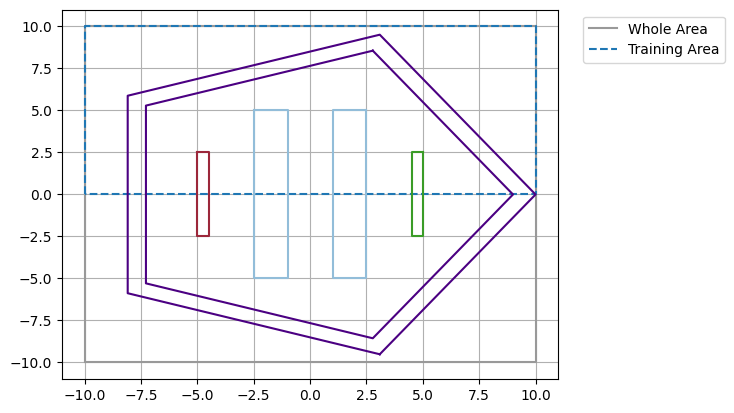

In [11]:
_ = builder.plot()

### Remove object

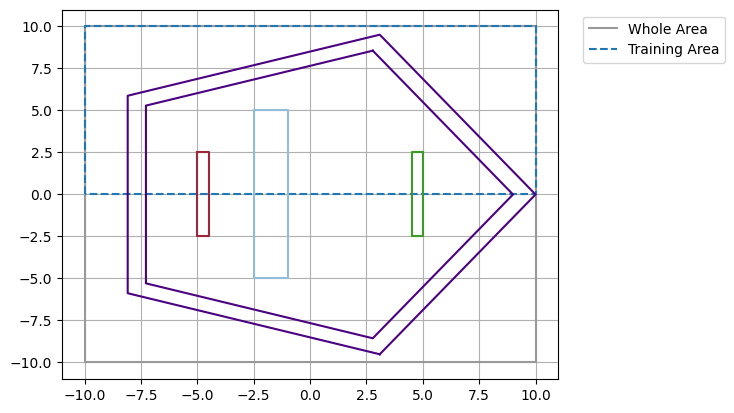

In [12]:
_ = builder.remove_object(-1).plot()

### Modify object

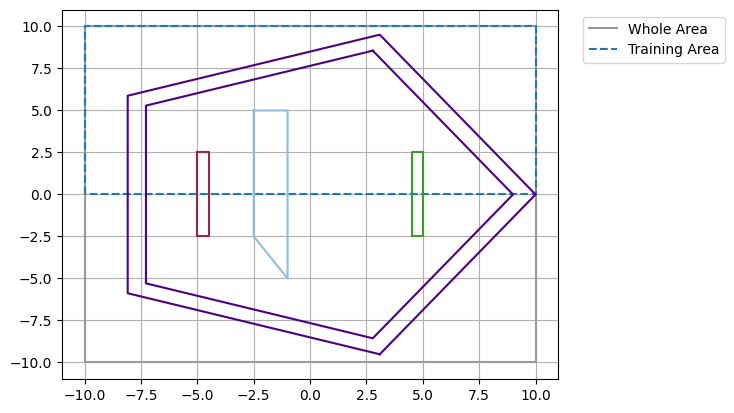

In [15]:
object_ = builder.objects[-1]
points_x, points_y = object_.exterior.xy
points_x[-2], points_y[-2] = (-2.5, -2.5) # the last point is the same as the first one, so we change the second last point
builder.objects[-1] = TexturedPolygon(
    zip(points_x, points_y),
    texture=builder.objects[-1].texture
)
_ = builder.plot()

## Save environment

In [16]:
builder.save('environment.ini')

### .ini file

```ini
[ExternalSources]
paths = 
variables = 

[GridBoundaries]
max_xy = 10
min_xy = -10
res = 0.2

[TrainingRectangle]
min_train_x = -10
min_train_y = 0
max_train_x = 10
max_train_y = 10

[BuildingBoundaries]
max_n_obj_points = 5
n_objects = 3
n_walls = 1

[Object1]
n_vertices = 5
exterior_x = -5.0, -5.0, -4.5, -4.5, -5.0
exterior_y = 2.5, -2.5, -2.5, 2.5, 2.5
interiors_x = 
interiors_y = 
texture_id = 21
texture_color = "#9c273a"
texture_name = "obj_bound_1"

[Object2]
n_vertices = 5
exterior_x = 5.0, 5.0, 4.5, 4.5, 5.0
exterior_y = 2.5, -2.5, -2.5, 2.5, 2.5
interiors_x = 
interiors_y = 
texture_id = 22
texture_color = "#3a9c27"
texture_name = "obj_bound_2"

[Object3]
n_vertices = 5
exterior_x = -2.5, -1.0, -1.0, -2.5, -2.5
exterior_y = 5.0, 5.0, -5.0, -2.5, 5.0
interiors_x = 
interiors_y = 
texture_id = 24
texture_color = "#92bdd9"
texture_name = "obj_bound_3"

[Wall1]
n_vertices = 6
exterior_x = 3.0901699437494723, -8.090169943749476, -8.090169943749473, 3.0901699437494745, 10.0, 3.0901699437494723
exterior_y = -9.510565162951536, -5.87785252292473, 5.877852522924733, 9.510565162951535, 0.0, -9.510565162951536
interiors_x = [[2.781152949374527, -7.281152949374526, -7.281152949374528, 2.7811529493745253, 9.0, 2.781152949374527]]
interiors_y = [[8.559508646656381, 5.290067270632259, -5.290067270632258, -8.559508646656383, 0.0, 8.559508646656381]]
texture_id = 1
texture_color = "#4b0082"
texture_name = "main_wall"
```

## Load environment

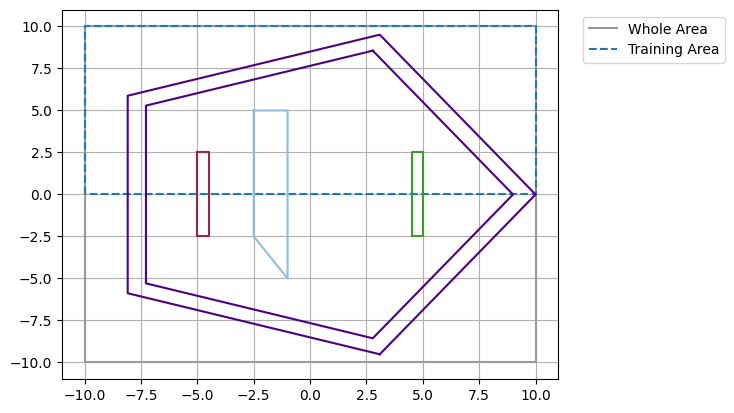

In [17]:
builder = EnvironmentBuilder.load('environment.ini')
fig = builder.plot()

## Compile environment

### Compile with precomputed visible plane

In [18]:
compiler = EnvironmentCompiler(builder)

start_time = time.time()
precomp_env = compiler.compile()
precomputed_runtime = time.time() - start_time

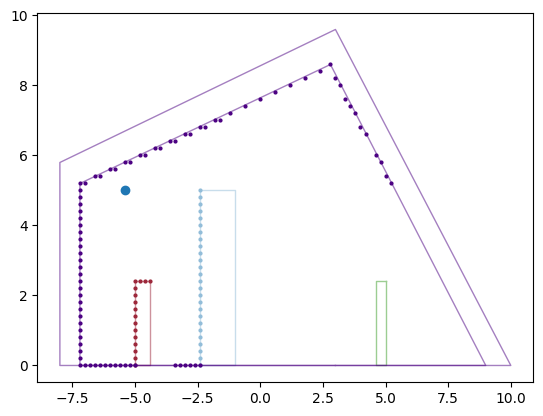

In [24]:
fig, ax = plt.subplots()
position = 1000 # the position of the agent (visible area has dimensionality n_positions x 2)
for i, obj in enumerate(precomp_env.objects + precomp_env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)
    ax.plot(
        obj.visible_parts[position, :, 0],
        obj.visible_parts[position, :, 1],
        'o',
        color=obj.polygon.texture.color,
        markersize=2
    )

ax.plot(
    precomp_env.visible_area.points[position, 0],
    precomp_env.visible_area.points[position, 1],
    'o'
)

### Compile with lazy visible plane

In [20]:
compiler = EnvironmentCompiler(builder, LazyVisiblePlane)

start_time = time.time()
lazy_env = compiler.compile()
lazy_runtime = time.time() - start_time

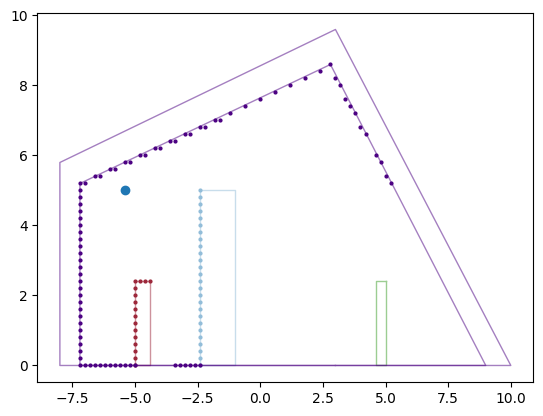

In [23]:
fig, ax = plt.subplots()
position = 1000
for i, obj in enumerate(lazy_env.objects + lazy_env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)
    ax.plot(
        obj.visible_parts[position, :, 0],
        obj.visible_parts[position, :, 1],
        'o',
        color=obj.polygon.texture.color,
        markersize=2
    )

ax.plot(
    lazy_env.visible_area.points[position, 0],
    lazy_env.visible_area.points[position, 1],
    'o'
)

### Compile with async visible plane

In [26]:
cache_manager = Cached(cache_storage=OrderedDict(), max_size=10000)
compiler = EnvironmentCompiler(
    builder,
    partial(
        AsyncVisiblePlane,
        n_neighbours=10,
        cache_manager=cache_manager,
    )
)

start_time = time.time()
async_env = compiler.compile()
async_runtime = time.time() - start_time

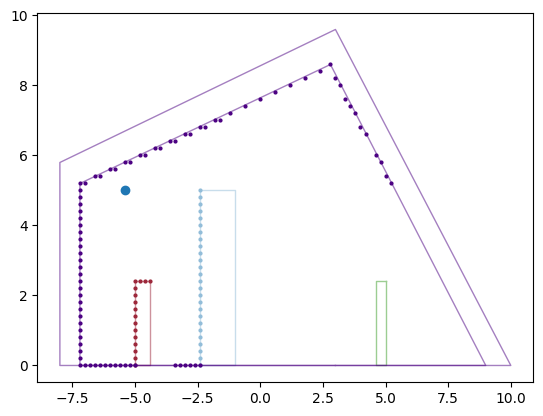

In [27]:
fig, ax = plt.subplots()
position = 1000
for i, obj in enumerate(async_env.objects + async_env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)
    ax.plot(
        obj.visible_parts[position, :, 0],
        obj.visible_parts[position, :, 1],
        'o',
        color=obj.polygon.texture.color,
        markersize=2
    )

ax.plot(
    async_env.visible_area.points[position, 0],
    async_env.visible_area.points[position, 1],
    'o'
)

### Efficiency comparison

##### Testing points

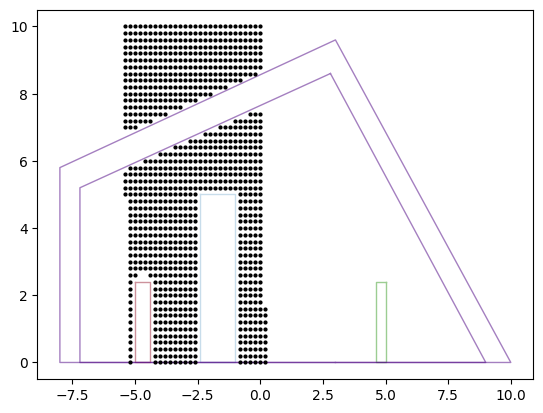

In [37]:
fig, ax = plt.subplots()
for i, obj in enumerate(async_env.objects + async_env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)

from_ = 1000
to = 2000
delay = .1

for position in range(from_, to):
    ax.plot(
        async_env.visible_area.points[position, 0],
        async_env.visible_area.points[position, 1],
        'o', color='black', markersize=2
    )

In [34]:
overall_start = time.time()
precomp_runtime_log = list()
for i in range(from_, to):
    tstart = time.time()
    _ = precomp_env.objects[0].visible_parts[i]
    tend = time.time()
    precomp_runtime_log.append(tend - tstart)
    time.sleep(delay) # simulate some other computation

precomp_overall = time.time() - overall_start

print(f'Oveall time: {precomp_overall}, average: {np.mean(precomp_runtime_log)}')

Oveall time: 100.12093305587769, average: 1.724696159362793e-05


In [35]:
overall_start = time.time()
lazy_runtime_log = list()
for i in range(from_, to):
    tstart = time.time()
    _ = lazy_env.objects[0].visible_parts[i]
    tend = time.time()
    lazy_runtime_log.append(tend - tstart)
    time.sleep(delay)

lazy_overall = time.time() - overall_start

print(f'Oveall time: {lazy_overall}, average: {np.mean(lazy_runtime_log)}')

Oveall time: 102.50497937202454, average: 0.0023948729038238527


In [38]:
overall_start = time.time()
async_runtime_log = list()
for i in range(from_, to):
    tstart = time.time()
    _ = async_env.objects[0].visible_parts[i]
    tend = time.time()
    async_runtime_log.append(tend - tstart)
    time.sleep(delay)

async_overall = time.time() - overall_start

print(f'Oveall time: {async_overall}, average: {np.mean(async_runtime_log)}')

Oveall time: 101.44605326652527, average: 0.0013408522605895996


Text(0, 0.5, 'Time (ms)')

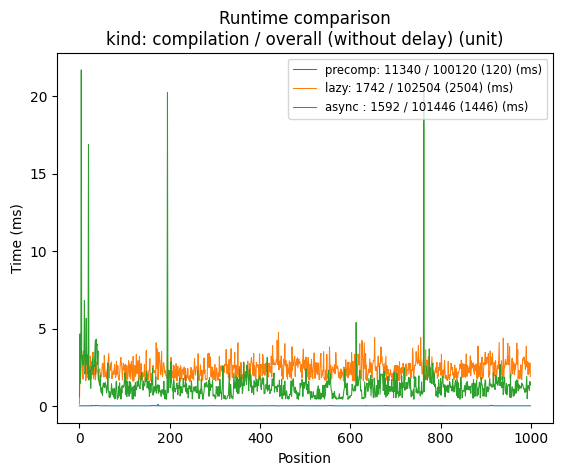

In [50]:
plt.plot(np.array(precomp_runtime_log)*1000, linewidth=0.75)
plt.plot(np.array(lazy_runtime_log)*1000, linewidth=0.75)
plt.plot(np.array(async_runtime_log)*1000, linewidth=0.75)

plt.legend([f'precomp: {int(precomputed_runtime*1000)} / {int(precomp_overall*1000)} ({int((precomp_overall - delay*(to - from_))*1000)}) (ms)',
            f'lazy: {int(lazy_runtime*1000)} / {int(lazy_overall*1000)} ({int((lazy_overall - delay*(to - from_))*1000)}) (ms)',
            f'async : {int(async_runtime*1000)} / {int(async_overall*1000)} ({int((async_overall - delay*(to - from_))*1000)}) (ms)'
        ], loc='upper right', fontsize='small')
plt.title('Runtime comparison\nkind: compilation / overall (without delay) (unit)')
plt.xlabel('Position')
plt.ylabel('Time (ms)')